In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt

In [2]:
input_parameters = pd.read_excel('1-s2.0-S0013468621012779-mmc2.xlsx', sheet_name='Input Parameters').dropna(how='all', axis=0)
input_parameters = input_parameters.set_index('Parameter')
input_parameters

,Symbol,Default value,Unit,User input?,User specified value,Used value
Parameter,,,,,,
Temperature,T,2.981500e+02,K,0.0,NaN,2.981500e+02
CO2 partial pressure,pCO2,1.000000e+00,atm,0.0,NaN,1.000000e+00
Flow rate,q,5.000000e-01,ml/min,1.0,5.0,5.000000e+00
Flow velocity,v,1.111111e-03,m/s,0.0,NaN,1.111111e-02
Flow channel active length,Lchannel,2.000000e-02,m,0.0,NaN,2.000000e-02
Flow channel height (plane parallel),hchannel,5.000000e-03,m,0.0,NaN,5.000000e-03
Flow channel width (plane perpendicular),wchannel,1.500000e-03,m,0.0,NaN,1.500000e-03
Catalyst layer length,L,3.810000e-06,m,0.0,NaN,3.810000e-06
Catalyst layer porosity,ε,5.000000e-01,-,0.0,NaN,5.000000e-01


In [3]:
input_parameters = input_parameters.to_dict()['Used value']

In [4]:
T = input_parameters['Temperature']
kco3_to_salinity = lambda x: x/(1.005*x/1000+19.924)
initial_carbonate_equilibria = {
    'Salinity': kco3_to_salinity(input_parameters['KHCO3 concentration']),
    'pK1_0': -126.34048 + 6320.813/T + 19.568224*np.log(T),
    'pK2_0': -90.18333 + 5143.692/T + 14.613358*np.log(T),
}
salinity_to_A1 = lambda x: 13.4191*x**0.5 + 0.0331*x - 5.33e-5*x**2
initial_carbonate_equilibria['A1'] = salinity_to_A1(initial_carbonate_equilibria['Salinity'])
salinity_to_A2 = lambda x: 21.0894*x**0.5 + 0.1248*x - 3.687e-4*x**2
initial_carbonate_equilibria['A2'] = salinity_to_A2(initial_carbonate_equilibria['Salinity'])
salinity_to_B1 = lambda x: -530.123*x**0.5 - 6.103*x
initial_carbonate_equilibria['B1'] = salinity_to_B1(initial_carbonate_equilibria['Salinity'])
salinity_to_B2 = lambda x: -772.483*x**0.5 - 20.051*x
initial_carbonate_equilibria['B2'] = salinity_to_B2(initial_carbonate_equilibria['Salinity'])
initial_carbonate_equilibria['C1'] = -2.0695*initial_carbonate_equilibria['Salinity']**0.5
initial_carbonate_equilibria['C2'] = -3.3336*initial_carbonate_equilibria['Salinity']**0.5
initial_carbonate_equilibria['pK1'] = initial_carbonate_equilibria['pK1_0'] + initial_carbonate_equilibria['A1'] + initial_carbonate_equilibria['B1']/T + initial_carbonate_equilibria['C1']*np.log(T)
initial_carbonate_equilibria['pK2'] = initial_carbonate_equilibria['pK2_0'] + initial_carbonate_equilibria['A2'] + initial_carbonate_equilibria['B2']/T + initial_carbonate_equilibria['C2']*np.log(T)
initial_carbonate_equilibria['K1'] = 10**-initial_carbonate_equilibria['pK1']
initial_carbonate_equilibria['K2'] = 10**-initial_carbonate_equilibria['pK2']
initial_carbonate_equilibria['Kw'] = np.exp(148.96502 - 13847.26/T - 23.6521*np.log(T) + (-5.977 + 118.67/T + 1.0495*np.log(T))*initial_carbonate_equilibria['Salinity']**0.5 - 0.01615*initial_carbonate_equilibria['Salinity'])

initial_carbonate_equilibria

{'Salinity': 24.47800651114973,
 'pK1_0': 6.351479474463076,
 'pK2_0': 10.329718047170417,
 'A1': 67.16962274581519,
 'A2': 107.17428008515591,
 'B1': -2772.186223903275,
 'B2': -4312.687688396103,
 'C1': -10.238903590992985,
 'C2': -16.493070312120906,
 'pK1': 5.886000594241267,
 'pK2': 9.068309507810866,
 'K1': 1.3001677990240674e-06,
 'K2': 8.544575512302501e-10,
 'Kw': 4.8746440592899435e-14}

In [5]:
diffusion_coefficients = {
    'CO2': 1.91e-09,
    'OH': 5.293e-09,
    'CO3': 9.23e-10,
    'HCO3': 1.18e-09,
    'H': 9.311e-09,
    'K': 1.96e-09,
    'CO': 2.03e-09,
    'H2': 4.5e-09
} # [m^2/s]
salting_out_exponents = {
    'h_OH': 6.67e-05,
    'h_CO3': 0.0001251,
    'h_HCO3': 7.95e-05,
    'h_K': 7.5e-05,
    'h_CO2': 0.0
} # [m^3/mol]

In [6]:
physical_constants = {
    'Henry constant': 1000*np.exp(93.4517*100/T - 60.2409 + 23.3585*np.log(T/100)), # [mol/(m^3 Pa)]
    'R': 8.3145, # [J/(mol K)]
    'F': 96485, # [C/mol]
}
physical_constants

{'Henry constant': 34.06103747827045, 'R': 8.3145, 'F': 96485}

In [7]:
electrode_reaction_kinetics = {
    'i_0_CO': 0.00471, # [A/m^2]
    'i_0_H2a': 0.00979, # [A/m^2]
    'i_0_H2b': 1.16e-05, # [A/m^2]
    'alpha_CO': 0.44,
    'alpha_H2a': 0.27,
    'alpha_H2b': 0.36,
    'E_0_CO2': -0.11, # [V]
    'E_0_H2a': 0.0, # [V]
    'E_0_H2b': 0.0 # [V]
}
electrode_reaction_kinetics['b_CO2'] = T*physical_constants['R']/(electrode_reaction_kinetics['alpha_CO']*physical_constants['F'])
electrode_reaction_kinetics['b_H2a'] = T*physical_constants['R']/(electrode_reaction_kinetics['alpha_H2a']*physical_constants['F'])
electrode_reaction_kinetics['b_H2b'] = T*physical_constants['R']/(electrode_reaction_kinetics['alpha_H2b']*physical_constants['F']) # 0.071368842, # for some reason spreadsheet has it hardcoded 
for substance in ['CO2','OH','CO3','HCO3','H','K','CO','H2']:
    electrode_reaction_kinetics[f'D{substance}'] = diffusion_coefficients[substance]*input_parameters['Catalyst layer porosity']**1.5
electrode_reaction_kinetics

{'i_0_CO': 0.00471,
 'i_0_H2a': 0.00979,
 'i_0_H2b': 1.16e-05,
 'alpha_CO': 0.44,
 'alpha_H2a': 0.27,
 'alpha_H2b': 0.36,
 'E_0_CO2': -0.11,
 'E_0_H2a': 0.0,
 'E_0_H2b': 0.0,
 'b_CO2': 0.058392688807021344,
 'b_H2a': 0.09515845583366442,
 'b_H2b': 0.07136884187524832,
 'DCO2': 6.752869760331528e-10,
 'DOH': 1.871358096410198e-09,
 'DCO3': 3.2632977951759173e-10,
 'DHCO3': 4.171930009000631e-10,
 'DH': 3.291935619813972e-09,
 'DK': 6.929646455628165e-10,
 'DCO': 7.177133829043458e-10,
 'DH2': 1.590990257669732e-09}

In [8]:
chemical_reaction_rates = {
    'k1f': 2.23, # [m^3/(mol s)]
    'k1r': 0.000840308, # [1/s]
    'k2f': 6000000.0, # [m^3/(mol s)]
    'k2r': 345200.0, # [1/s]
    'c_ref': 1000.0 # [mol/m^3]
    }

In [9]:
dic_electrolyte_solution = {
    'A': 1,
    'B': initial_carbonate_equilibria['K1'] + input_parameters['KHCO3 concentration']/1000,
    'C': initial_carbonate_equilibria['K1']*initial_carbonate_equilibria['K2'] - initial_carbonate_equilibria['Kw'],
    'D': -initial_carbonate_equilibria['K1']*(initial_carbonate_equilibria['Kw'] + initial_carbonate_equilibria['K2']*input_parameters['KHCO3 concentration']/1000),
    'E': -initial_carbonate_equilibria['Kw']*initial_carbonate_equilibria['K2']*initial_carbonate_equilibria['K1'],
    'initial_pH': 7,
}
x_n = 1e-4
f_xn = lambda x: dic_electrolyte_solution['A']*x**4 + dic_electrolyte_solution['B']*x**3 + dic_electrolyte_solution['C']*x**2 + dic_electrolyte_solution['D']*x + dic_electrolyte_solution['E']
df_xn = lambda x: 4*dic_electrolyte_solution['A']*x**3 + 3*dic_electrolyte_solution['B']*x**2 + 2*dic_electrolyte_solution['C']*x + dic_electrolyte_solution['D']
# find root of f(x) = 0
x_n = opt.newton(f_xn, x_n, fprime=df_xn, tol=1e-35)
dic_electrolyte_solution['final_pH'] = -np.log10(x_n)
dic_electrolyte_solution['CO2'] = input_parameters['KHCO3 concentration']/(1 + initial_carbonate_equilibria['K1']/x_n + initial_carbonate_equilibria['K1']*initial_carbonate_equilibria['K2']/x_n**2)
dic_electrolyte_solution['HCO3'] = dic_electrolyte_solution['CO2']*initial_carbonate_equilibria['K1']/x_n
dic_electrolyte_solution['CO3'] = dic_electrolyte_solution['HCO3']*initial_carbonate_equilibria['K2']/x_n
dic_electrolyte_solution['OH'] = initial_carbonate_equilibria['Kw']/x_n * 1000
dic_electrolyte_solution['K'] = input_parameters['K+']
dic_electrolyte_solution

{'A': 1,
 'B': 0.500001300167799,
 'C': -4.7635502399156905e-14,
 'D': -5.555324754236402e-16,
 'E': -5.415428266365318e-29,
 'initial_pH': 7,
 'final_pH': 7.477129599560376,
 'CO2': 12.193436804360426,
 'HCO3': 475.6145554799038,
 'CO3': 12.192007715735759,
 'OH': 0.0014624213175124347,
 'K': 500.0}

In [10]:
co2_equilibrium_sol = {
    'CO2_0_before': physical_constants['Henry constant']*input_parameters['Method 1 (DIC)'],
    'A': 1,
    'B': input_parameters['KHCO3 concentration']/1000,
}
co2_equilibrium_sol['C'] = -(initial_carbonate_equilibria['Kw'] + initial_carbonate_equilibria['K1']*co2_equilibrium_sol['CO2_0_before']/1000)
co2_equilibrium_sol['D'] = -2*co2_equilibrium_sol['CO2_0_before']/1000*initial_carbonate_equilibria['K1']*initial_carbonate_equilibria['K2']
f_xn = lambda x: co2_equilibrium_sol['A']*x**3 + co2_equilibrium_sol['B']*x**2 + co2_equilibrium_sol['C']*x + co2_equilibrium_sol['D']
df_xn = lambda x: 3*co2_equilibrium_sol['A']*x**2 + 2*co2_equilibrium_sol['B']*x + co2_equilibrium_sol['C']
x_n = 1e-5
# find root of f(x) = 0
x_n = opt.newton(f_xn, x_n, fprime=df_xn, tol=1e-35)
x_n
co2_equilibrium_sol['CO2_1'] = physical_constants['Henry constant']*input_parameters['Method 1 (DIC)']*np.exp(
    -input_parameters['K+']*salting_out_exponents['h_K'] - 
    salting_out_exponents['h_HCO3']*co2_equilibrium_sol['CO2_0_before']*initial_carbonate_equilibria['K1']/x_n -
    co2_equilibrium_sol['CO2_0_before']*salting_out_exponents['h_CO3']*initial_carbonate_equilibria['K1']*initial_carbonate_equilibria['K2']/x_n**2 -
    salting_out_exponents['h_OH']*initial_carbonate_equilibria['Kw']/x_n*1000)
co2_equilibrium_sol['C'] = -(initial_carbonate_equilibria['Kw'] + initial_carbonate_equilibria['K1']*co2_equilibrium_sol['CO2_1']/1000)
co2_equilibrium_sol['D'] = -2*co2_equilibrium_sol['CO2_1']/1000*initial_carbonate_equilibria['K1']*initial_carbonate_equilibria['K2']
f_xn = lambda x: co2_equilibrium_sol['A']*x**3 + co2_equilibrium_sol['B']*x**2 + co2_equilibrium_sol['C']*x + co2_equilibrium_sol['D']
df_xn = lambda x: 3*co2_equilibrium_sol['A']*x**2 + 2*co2_equilibrium_sol['B']*x + co2_equilibrium_sol['C']
x_n = 1e-5
# find root of f(x) = 0
x_n = opt.newton(f_xn, x_n, fprime=df_xn, tol=1e-35)
x_n
co2_equilibrium_sol['CO2_2'] = physical_constants['Henry constant']*input_parameters['Method 1 (DIC)']*np.exp(
    -input_parameters['K+']*salting_out_exponents['h_K'] - 
    salting_out_exponents['h_HCO3']*co2_equilibrium_sol['CO2_1']*initial_carbonate_equilibria['K1']/x_n -
    co2_equilibrium_sol['CO2_1']*salting_out_exponents['h_CO3']*initial_carbonate_equilibria['K1']*initial_carbonate_equilibria['K2']/x_n**2 -
    salting_out_exponents['h_OH']*initial_carbonate_equilibria['Kw']/x_n*1000)
co2_equilibrium_sol['C'] = -(initial_carbonate_equilibria['Kw'] + initial_carbonate_equilibria['K1']*co2_equilibrium_sol['CO2_2']/1000)
co2_equilibrium_sol['D'] = -2*co2_equilibrium_sol['CO2_2']/1000*initial_carbonate_equilibria['K1']*initial_carbonate_equilibria['K2']
x_n = 1e-5
f_xn = lambda x: co2_equilibrium_sol['A']*x**3 + co2_equilibrium_sol['B']*x**2 + co2_equilibrium_sol['C']*x + co2_equilibrium_sol['D']
df_xn = lambda x: 3*co2_equilibrium_sol['A']*x**2 + 2*co2_equilibrium_sol['B']*x + co2_equilibrium_sol['C']
# find root of f(x) = 0
x_n = opt.newton(f_xn, x_n, fprime=df_xn, tol=1e-35)
x_n
co2_equilibrium_sol['CO2'] = physical_constants['Henry constant']*input_parameters['Method 1 (DIC)']*np.exp(
    -input_parameters['K+']*salting_out_exponents['h_K'] - 
    salting_out_exponents['h_HCO3']*co2_equilibrium_sol['CO2_2']*initial_carbonate_equilibria['K1']/x_n -
    co2_equilibrium_sol['CO2_2']*salting_out_exponents['h_CO3']*initial_carbonate_equilibria['K1']*initial_carbonate_equilibria['K2']/x_n**2 -
    salting_out_exponents['h_OH']*initial_carbonate_equilibria['Kw']/x_n*1000)
co2_equilibrium_sol['HCO3'] = co2_equilibrium_sol['CO2']*initial_carbonate_equilibria['K1']/x_n
co2_equilibrium_sol['CO3'] = co2_equilibrium_sol['HCO3']*initial_carbonate_equilibria['K2']/x_n
co2_equilibrium_sol['OH'] = initial_carbonate_equilibria['Kw']/x_n * 1000
co2_equilibrium_sol['K'] = input_parameters['K+']
co2_equilibrium_sol['final_pH'] = -np.log10(x_n) # there was a mistake on the spreadsheet! The final value of pH wasn't taken from converged value of x_n
# final value of pH on spreadsheet is 8.01
# co2_equilibrium_sol['final_pH'] = 8.01
co2_equilibrium_sol

{'CO2_0_before': 0.013312446399625793,
 'A': 1,
 'B': 0.5,
 'C': -1.618921484478755e-11,
 'D': -2.758269021671477e-20,
 'CO2_1': 0.01241369680095453,
 'CO2_2': 0.012414142556299286,
 'CO2': 0.012414142330721344,
 'HCO3': 64.14630439620163,
 'CO3': 217.82997804194167,
 'OH': 0.1937306895325273,
 'K': 500.0,
 'final_pH': 9.599255514698061}

In [11]:
flow_channel_characteristics = {
    'mu': 0.00000093944, # [m^2/s]
}
flow_channel_characteristics['Reynolds Number'] = input_parameters['Flow velocity']*input_parameters['Flow channel active length']/flow_channel_characteristics['mu']
flow_channel_characteristics['Hydrodynamic Entrance length'] = 0.0099*flow_channel_characteristics['Reynolds Number']*input_parameters['Flow channel width (plane perpendicular)']
flow_channel_characteristics['Parallel plate effective boundary layer'] = 13/35*input_parameters['Flow channel width (plane perpendicular)']
diff_coeff_to_bl_thickness = lambda x: 3*1.607/4*(input_parameters['Flow channel width (plane perpendicular)']*x*input_parameters['Flow channel active length']/input_parameters['Flow velocity'])**(1/3)
diff_coeff_to_K_L = lambda D,L: D*np.sqrt(L**-2+flow_channel_characteristics['Parallel plate effective boundary layer']**-2)/np.sqrt(2)
for substance in ['CO2', 'OH', 'CO3', 'HCO3', 'H', 'K', 'CO', 'H2']:
    flow_channel_characteristics[f'Developing boundary layer thickness {substance} (average)'] = diff_coeff_to_bl_thickness(diffusion_coefficients[substance])
for substance in ['CO2', 'OH', 'CO3', 'HCO3', 'H', 'K', 'CO', 'H2']:
    flow_channel_characteristics[f'K_L_{substance}'] = diff_coeff_to_K_L(diffusion_coefficients[substance], flow_channel_characteristics[f'Developing boundary layer thickness {substance} (average)'])

flow_channel_characteristics

{'mu': 9.3944e-07,
 'Reynolds Number': 236.54754132485544,
 'Hydrodynamic Entrance length': 0.003512730988674104,
 'Parallel plate effective boundary layer': 0.0005571428571428572,
 'Developing boundary layer thickness CO2 (average)': 0.0002082297849599541,
 'Developing boundary layer thickness OH (average)': 0.00029248192081643507,
 'Developing boundary layer thickness CO3 (average)': 0.00016340510807976482,
 'Developing boundary layer thickness HCO3 (average)': 0.00017734776946557972,
 'Developing boundary layer thickness H (average)': 0.00035307245480052283,
 'Developing boundary layer thickness K (average)': 0.00021003117016132972,
 'Developing boundary layer thickness CO (average)': 0.00021250235181041242,
 'Developing boundary layer thickness H2 (average)': 0.0002770783330176991,
 'K_L_CO2': 6.924176126360003e-06,
 'K_L_OH': 1.4452520065854136e-05,
 'K_L_CO3': 4.162362825522188e-06,
 'K_L_HCO3': 4.937409025723504e-06,
 'K_L_H': 2.2076471242713813e-05,
 'K_L_K': 7.051993347990138e

In [12]:
phi_ext = np.linspace(0, -1.200, 241)
a = input_parameters['Catalyst layer volumetric surface area']
F = physical_constants['F']
k0 = a/(2*F) * electrode_reaction_kinetics['i_0_CO']/chemical_reaction_rates['c_ref'] * np.exp(
    -(0.11+phi_ext)/(electrode_reaction_kinetics['b_CO2']))
eff_0 = 1/(
    np.sqrt(k0*input_parameters['Catalyst layer length']**2/electrode_reaction_kinetics['DCO2'])
/(
    np.tanh(np.sqrt(k0*input_parameters['Catalyst layer length']**2/electrode_reaction_kinetics['DCO2']))
) + k0*input_parameters['Catalyst layer length']/input_parameters['Gas diffusion layer mass transfer coefficient']
)
c00 = physical_constants['Henry constant']*input_parameters['CO2 partial pressure']*eff_0
r_H2 = input_parameters['Catalyst layer volumetric surface area']*electrode_reaction_kinetics['i_0_H2b']/physical_constants['F']*np.exp(-phi_ext/electrode_reaction_kinetics['b_H2b'])
c10 = input_parameters['OH-']+(
    flow_channel_characteristics['K_L_OH']*input_parameters['OH-'] - 
    1/(
        1/(input_parameters['Catalyst layer length']*(r_H2+2*k0*c00)) +
        1/(flow_channel_characteristics['K_L_HCO3']*input_parameters['HCO3-'])
       )
    + input_parameters['Catalyst layer length']*(r_H2+2*k0*c00)
) / (
    flow_channel_characteristics['K_L_OH'] + 2*input_parameters['Catalyst layer porosity']*input_parameters['Catalyst layer length']*chemical_reaction_rates['k1f']*c00
)
k1 = input_parameters['Catalyst layer volumetric surface area']/(2*physical_constants['F']) * electrode_reaction_kinetics['i_0_CO']/chemical_reaction_rates['c_ref']*np.exp(-(phi_ext+0.11)/electrode_reaction_kinetics['b_CO2']) + input_parameters['Catalyst layer porosity']*chemical_reaction_rates['k1f']*c10
eff_1 = 1/(
    np.sqrt(
        k1*input_parameters['Catalyst layer length']**2/electrode_reaction_kinetics['DCO2']
    ) / np.tanh(np.sqrt(
        k1*input_parameters['Catalyst layer length']**2/electrode_reaction_kinetics['DCO2']
    )) + k1*input_parameters['Catalyst layer length']/input_parameters['Gas diffusion layer mass transfer coefficient']
)
c01 = eff_1*input_parameters['CO2 partial pressure']*physical_constants['Henry constant']
c11 = input_parameters['OH-'] + (
    flow_channel_characteristics['K_L_OH']*input_parameters['OH-'] - 1/(
        1/(input_parameters['Catalyst layer length']*(r_H2+2*k0*c01)) + 1/(flow_channel_characteristics['K_L_HCO3']*input_parameters['HCO3-'])
    ) + input_parameters['Catalyst layer length']*(r_H2+2*k0*c01) 
    ) / (
    flow_channel_characteristics['K_L_OH']+2*chemical_reaction_rates['k1f']*input_parameters['Catalyst layer length']*input_parameters['Catalyst layer porosity']*c01
)
A_1 = (
    2*flow_channel_characteristics['K_L_CO3']*input_parameters['CO32-'] + flow_channel_characteristics['K_L_HCO3']*input_parameters['HCO3-'] + flow_channel_characteristics['K_L_OH']*input_parameters['OH-'] + input_parameters['Catalyst layer length']*r_H2 - flow_channel_characteristics['K_L_OH']*c11
) / (2*flow_channel_characteristics['K_L_CO3'])
B_2 = input_parameters['Catalyst layer length']*2*k0*c01 / (2*flow_channel_characteristics['K_L_CO3']) * np.exp(-c11*(salting_out_exponents['h_OH']+salting_out_exponents['h_K']))
c20 = A_1+np.log(
    1+(
        B_2*(salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K']) * np.exp(-A_1*(salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K']))
        ) / (
            1+np.log(np.sqrt(1+B_2*(salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K'])*np.exp(-A_1*(salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K']))))
            )
    ) / (
    salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K']
)
c02 = input_parameters['CO2 partial pressure']*physical_constants['Henry constant']*np.exp(-salting_out_exponents['h_OH']*c11-salting_out_exponents['h_CO3']*c20-salting_out_exponents['h_K']*(c11+2*c20))*eff_1
c12 = input_parameters['OH-'] + (
    flow_channel_characteristics['K_L_OH']*input_parameters['OH-'] - 1/(
        1/(input_parameters['Catalyst layer length']*(r_H2+2*k0*c02)) + 1/(flow_channel_characteristics['K_L_HCO3']*input_parameters['HCO3-'])
    ) + input_parameters['Catalyst layer length']*(r_H2+2*k0*c02)
    ) / (
    flow_channel_characteristics['K_L_OH']+2*chemical_reaction_rates['k1f']*input_parameters['Catalyst layer length']*input_parameters['Catalyst layer porosity']*c02
)
k2 = input_parameters['Catalyst layer volumetric surface area']/(2*physical_constants['F']) * electrode_reaction_kinetics['i_0_CO']/chemical_reaction_rates['c_ref']*np.exp(-(phi_ext+0.11)/electrode_reaction_kinetics['b_CO2']) + input_parameters['Catalyst layer porosity']*chemical_reaction_rates['k1f']*c12
eff_2 = 1/(
    np.sqrt(
        k2*input_parameters['Catalyst layer length']**2/electrode_reaction_kinetics['DCO2']
    ) / np.tanh(np.sqrt(
        k2*input_parameters['Catalyst layer length']**2/electrode_reaction_kinetics['DCO2']
    )) + k2*input_parameters['Catalyst layer length']/input_parameters['Gas diffusion layer mass transfer coefficient']
)
A_1_1 = (
    2*flow_channel_characteristics['K_L_CO3']*input_parameters['CO32-'] + flow_channel_characteristics['K_L_HCO3']*input_parameters['HCO3-'] + flow_channel_characteristics['K_L_OH']*input_parameters['OH-'] + input_parameters['Catalyst layer length']*r_H2 - flow_channel_characteristics['K_L_OH']*c12
) / (2*flow_channel_characteristics['K_L_CO3'])
# formula for this B2 is different than for the previous B2
B_2_1 = input_parameters['Catalyst layer length']*2*k0*eff_2*physical_constants['Henry constant']*input_parameters['CO2 partial pressure'] / (2*flow_channel_characteristics['K_L_CO3']) * np.exp(-c12*(salting_out_exponents['h_OH']+salting_out_exponents['h_K']))
c21 = A_1_1+np.log(
    1+(
        B_2_1*(salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K']) * np.exp(-A_1_1*(salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K']))
        ) / (
            1+np.log(np.sqrt(1+B_2_1*(salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K'])*np.exp(-A_1_1*(salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K']))))
            )
    ) / (
    salting_out_exponents['h_CO3']+2*salting_out_exponents['h_K']
)
c21 = np.maximum(c21, 0)
c03 = input_parameters['CO2 partial pressure']*physical_constants['Henry constant']*np.exp(-salting_out_exponents['h_OH']*c12-salting_out_exponents['h_CO3']*c21-salting_out_exponents['h_K']*(c12+2*c21))*eff_2
potential_vs_rhe = phi_ext - physical_constants['R']*T/physical_constants['F']*np.log(c12/input_parameters['OH-'])
co_current_density = input_parameters['Catalyst layer length']*c03*k0*2*physical_constants['F']/10
co2 = c03
co3 = c21
pH = np.log10(c12/1000/initial_carbonate_equilibria['Kw'])
fe = co_current_density*10/(co_current_density*10+(physical_constants['F']*input_parameters['Catalyst layer length']*r_H2))
parasitic = c03*c12*input_parameters['Catalyst layer porosity']*input_parameters['Catalyst layer length']*chemical_reaction_rates['k1f']
electrode = input_parameters['Catalyst layer length']*k0*c03
gdl_flux = input_parameters['Gas diffusion layer mass transfer coefficient']*(
    physical_constants['Henry constant']*input_parameters['CO2 partial pressure']*np.exp(
        -salting_out_exponents['h_OH']*c12-salting_out_exponents['h_CO3']*c21-salting_out_exponents['h_K']*(c12+2*c21)
    ) - c03*np.sqrt(
        k2*input_parameters['Catalyst layer length']**2/electrode_reaction_kinetics['DCO2']
    ) / np.tanh(
        np.sqrt(k2*input_parameters['Catalyst layer length']**2/electrode_reaction_kinetics['DCO2'])
    )
)
ve_rhe = (electrode_reaction_kinetics['E_0_CO2'] - physical_constants['R']*T/physical_constants['F']*np.log(c12/input_parameters['OH-']))/potential_vs_rhe
ve_rhe = np.minimum(ve_rhe, 1)
hco3 = np.minimum(
    input_parameters['HCO3-']+physical_constants['Henry constant']*input_parameters['CO2 partial pressure']*np.exp(
        -salting_out_exponents['h_OH']*c12-salting_out_exponents['h_CO3']*c21-salting_out_exponents['h_K']*(c12+2*c21)
    ),
    co3*10**(3-pH)/initial_carbonate_equilibria['K1']
)
ee = np.minimum(1, fe*ve_rhe)
ve_she = (electrode_reaction_kinetics['E_0_CO2'] - physical_constants['R']*T/physical_constants['F']*pH) / (
    phi_ext - physical_constants['R']*T/physical_constants['F']*pH
)
ve_she = np.minimum(1, ve_she)
ve_agcl = (electrode_reaction_kinetics['E_0_CO2'] - physical_constants['R']*T/physical_constants['F']*pH - 0.2) / (
    phi_ext - physical_constants['R']*T/physical_constants['F']*pH - 0.2
)
ve_agcl = np.minimum(1, ve_agcl)
eeshe = fe*ve_she
eeagcl = fe*ve_agcl
solubility = np.exp(
    -salting_out_exponents['h_OH']*c12 - salting_out_exponents['h_CO3']*c21 - salting_out_exponents['h_K']*(c12+2*c21)
)

In [13]:
varying_potential = pd.read_excel('./1-s2.0-S0013468621012779-mmc2.xlsx', sheet_name='Varying Potential')
column_map = {
    'A_1.1': 'A_1_1',
    'B_2.1': 'B_2_1',
    'Potential vs RHE': 'potential_vs_rhe',
    'CO Current Density (mA/cm^2)': 'co_current_density',
    'CO2 (mol/m^3)': 'co2',
    'CO3 (mol/m^3)': 'co3',
    'FE': 'fe',
    'HCO3 (mol/m^3)': 'hco3',
    'VE(RHE)': 've_rhe',
    'EE(%)': 'ee',
    'VE(SHE%)': 've_she',
    'VE(Ag/Cl%)': 've_agcl',
    'EEAg/Cl': 'eeagcl',
}
for col in varying_potential.columns[4:]:
    from_spreadsheet = varying_potential[col].values
    try:
        if col in column_map:
            from_python = eval(column_map[col])
        else:
            col = col.replace(' ', '_')
            from_python = eval(col)
        # print(f'{col} is OK')
    except:
        try:
            from_python = eval(col[0].lower()+col[1:])
            # print(f'{col} is OK')
        except:
            try:
                from_python = eval(col.lower())
            except:
                print(f'Error in {col}')
    if not np.allclose(from_spreadsheet, from_python, rtol=1e-2):
        plt.scatter(from_spreadsheet, from_python, s=1)
        plt.axline([0,0], slope=1, color='k', lw=0.5)
        plt.title(col)
        print(f'{col} mismatch')
        plt.show()

Reproduced curve from Figure 6b (FE vs voltage)

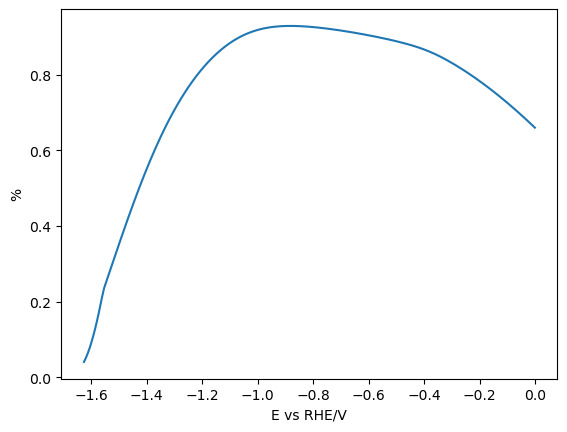

In [14]:
plt.plot(potential_vs_rhe, fe)
plt.xlabel('E vs RHE/V')
plt.ylabel('%')
plt.show()